# Customizing Hypothesis Function on KNN-TSPI

In this notebook we show how to customize the hypothesis function that maps the one step ahead observation of the most similar queries to the input query into the forecasted value. The user can define what the weights will be in terms of the distances between the input query and its nearest neighbors when the label is computed as a weighted average instead of simple mean.

We highly recommend to read the [Forecasting with Confidence with KNN-TSPI](./forecasting-with-confidence.ipynb) notebook before diving into this one, since we will skip the explanation of some steps that we already did in the aforementioned.

The time series chosen was the `wineind` - Australian total wine sales by wine makers in bottles <= 1 litre. It records wine sales by Australian wine makers between Jan 1980 – Aug 1994.

In [ ]:
!pip install matplotlib pmdarima

In [5]:
from knn_tspi import KNeighborsTSPI
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.datasets import load_wineind

In [2]:
data = load_wineind()
data

array([15136., 16733., 20016., 17708., 18019., 19227., 22893., 23739.,
       21133., 22591., 26786., 29740., 15028., 17977., 20008., 21354.,
       19498., 22125., 25817., 28779., 20960., 22254., 27392., 29945.,
       16933., 17892., 20533., 23569., 22417., 22084., 26580., 27454.,
       24081., 23451., 28991., 31386., 16896., 20045., 23471., 21747.,
       25621., 23859., 25500., 30998., 24475., 23145., 29701., 34365.,
       17556., 22077., 25702., 22214., 26886., 23191., 27831., 35406.,
       23195., 25110., 30009., 36242., 18450., 21845., 26488., 22394.,
       28057., 25451., 24872., 33424., 24052., 28449., 33533., 37351.,
       19969., 21701., 26249., 24493., 24603., 26485., 30723., 34569.,
       26689., 26157., 32064., 38870., 21337., 19419., 23166., 28286.,
       24570., 24001., 33151., 24878., 26804., 28967., 33311., 40226.,
       20504., 23060., 23562., 27562., 23940., 24584., 34303., 25517.,
       23494., 29095., 32903., 34379., 16991., 21109., 23740., 25552.,
      

In this case, the weights will be set to `distance` instead of `uniform` which is the default value.

In [3]:
k = 3
len_query = 12
weights = "distance"
h = 24

knn = KNeighborsTSPI(k=k, len_query=len_query, weights=weights)
knn

KNeighborsTSPI(k=3, len_query=12, weights="distance")

In [4]:
knn.fit(data)

We define a funcion g that takes an array of distances as input, i.e., the distances between the input query and its nearest neighbors retrieved from the historical data passed to the fit method and maps it into a weights array.

Usually, it is used a strictly decreasing function since smaller distances should yield larger weights due to the KNN assumption.

Finally, we pass a pointer to the g function on the `predict` or `predict_internal` methods and the new hypothesis will be used to forecast the time series.

In [6]:
def g(distances: np.ndarray) -> np.ndarray:
    return np.exp(-distances)

In [7]:
y = knn.predict_interval(h=h, g=g)
y

{'low_95': array([22654.29568146, 25076.38373603, 30086.14174437, 33137.44095697,
        16667.74405248, 20109.82472533, 22401.36630503, 24654.8750249 ,
        22241.79319385, 21585.89785852, 28240.19992418, 24692.8592104 ,
        22670.53738131, 24943.61106616, 29026.40973059, 33572.76879012,
        16878.53170634, 19684.70720416, 23278.48405687, 26620.28417441,
        22729.08539103, 23450.68732744, 26929.21251414, 26223.19128156]),
 'low_80': array([22952.39891962, 25184.91440592, 30306.45469835, 33339.07090395,
        16848.41021238, 20224.59336519, 22674.93628285, 24926.73446574,
        22355.68989468, 21895.5785684 , 28434.06699006, 25000.97724211,
        22868.7770002 , 25228.33989615, 29238.47284824, 33716.60612854,
        17047.08915999, 19745.35542087, 23463.75280136, 27000.86750087,
        22969.10883909, 23616.68917613, 27289.75445893, 26416.25895241]),
 'mean': array([24141.09188394, 26348.65549035, 31303.56505532, 34294.94407143,
        17845.52056935, 21382.09

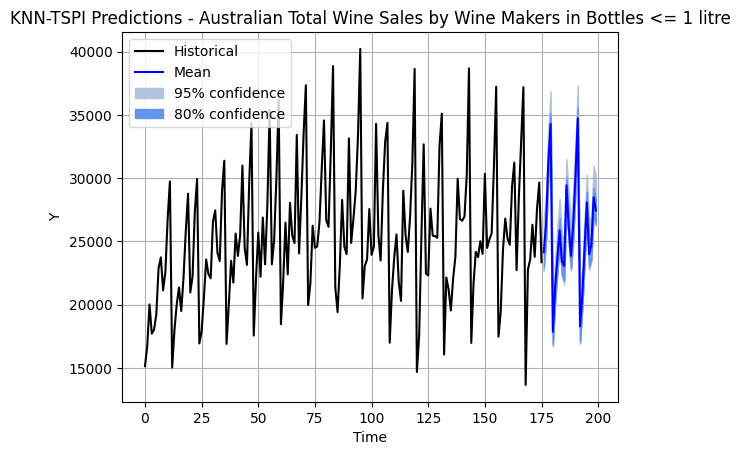

In [8]:
rng = range(len(data), len(data) + h)
plt.title("KNN-TSPI Predictions - Australian Total Wine Sales by Wine Makers in Bottles <= 1 litre")
plt.plot(data, color="black", label="Historical")
plt.plot(rng, y["mean"], color="blue", label="Mean")
plt.fill_between(
    rng,
    y["low_80"],
    y["low_95"],
    color="lightsteelblue",
)
plt.fill_between(
    rng,
    y["high_80"],
    y["high_95"],
    color="lightsteelblue",
    label="95% confidence",
)
plt.fill_between(
    rng, y["low_80"], y["high_80"], color="cornflowerblue", label="80% confidence"
)
plt.grid()
plt.xlabel("Time")
plt.ylabel("Y")
plt.legend(loc="upper left")
plt.show()